In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import simfromcsv
import pickle

In [16]:
# stochastic BPM model
r = 5 # each infected cell produces r_i^2 virions of the ith mutant type
p = 10**-5
mu = [1, p, p**2, p**3, p**4, p**5]
mu[0] -= np.sum(mu[1:5])
g = 0.5 / 2
def BPM_st(t, g, r, mu):
    n = [1, 0, 0, 0, 0, 0]
    i = 0 # starting time
    while i < t:
        i += g
        n[0] = st.poisson.rvs(n[0]*r*mu[0])
        n[1] = st.poisson.rvs(r*(n[1]*mu[0] + n[0]*mu[1]))
        n[2] = st.poisson.rvs(r*(n[2]*mu[0] + n[1]*mu[1] + n[0]*mu[2]))
        n[3] = st.poisson.rvs(r*(n[3]*mu[0] + n[2]*mu[1] + n[1]*mu[2] + n[0]*mu[3]))
        n[4] = st.poisson.rvs(r*(n[4]*mu[0] + n[3]*mu[1] + n[2]*mu[2] + n[1]*mu[3] + n[0]*mu[4]))
        n[5] = st.poisson.rvs(r*(n[5]*mu[0] + n[4]*mu[1] + n[3]*mu[2] + n[2]*mu[3] + n[1]*mu[4] + n[0]*mu[5]))
    return n

In [2]:
#Vectorised version of the BPM
def BPM_st_vectorised(t, g, r, mu, initial_v):
    n_list = [[initial_v, 0, 0, 0, 0, 0]]
    i = 0 # starting time
    count=0 #index
    while (i <= t - g):
        i += g
        n = np.copy(n_list[count])
        n_new = np.zeros(6)
        n_new[0] = st.poisson.rvs(n[0]*r[count]*mu[0])
        n_new[1] = st.poisson.rvs(r[count]*(n[1]*mu[0])) +  st.poisson.rvs(r[count] * (n[0]*mu[1]))
        n_new[2] = st.poisson.rvs(r[count]*(n[2]*mu[0])) +  st.poisson.rvs(r[count] * ( n[1]*mu[1] )) +  st.poisson.rvs(r[count] * ( n[0]*mu[2]))
        n_new[3] = st.poisson.rvs(r[count]*(n[3]*mu[0] )) +  st.poisson.rvs(r[count] * ( n[2]*mu[1] )) +  st.poisson.rvs(r[count] * ( n[1]*mu[2] )) +  st.poisson.rvs(r[count] * ( n[0]*mu[3]))
        n_new[4] = st.poisson.rvs(r[count]*(n[4]*mu[0] )) +  st.poisson.rvs(r[count] * ( n[3]*mu[1] )) +  st.poisson.rvs(r[count] * ( n[2]*mu[2] )) +  st.poisson.rvs(r[count] * ( n[1]*mu[3] )) +  st.poisson.rvs(r[count] * ( n[0]*mu[4]))
        n_new[5] = st.poisson.rvs(r[count]*(n[5]*mu[0] )) +  st.poisson.rvs(r[count] * ( n[4]*mu[1] )) +  st.poisson.rvs(r[count] * ( n[3]*mu[2] )) +  st.poisson.rvs(r[count] * ( n[2]*mu[3] )) +  st.poisson.rvs(r[count] * ( n[1]*mu[4] )) +  st.poisson.rvs(r[count] * ( n[0]*mu[5]))
        count +=1
        n_list.append(np.copy(n_new))
        #stores the virion counts at every time point
    return n_list

In [ ]:
#Get the r and lifespan parameters
g = 0.5 / 2
params = simfromcsv.getBPMparams(g)
Lifespans = params[0]
r_vals = params[1]
Deaths = params[2]

np.savetxt('Results/Lifespans_adaptive.csv',Lifespans,delimiter=',')
np.savetxt('Results/r_vals_adaptive.csv',r_vals,delimiter=',')
np.savetxt('Results/Deaths_adaptive.csv',Deaths,delimiter=',')

In [3]:
# Alternatively load corresponding csv files in
g = 0.5 / 2
Lifespans = np.genfromtxt('Results/Lifespans_adaptive.csv',delimiter=',')
r_vals = np.genfromtxt('Results/r_vals_adaptive.csv',delimiter=',')
Deaths = np.genfromtxt('Results/Deaths_adaptive.csv',delimiter=',')

In [4]:
#Set parameters
p = 10**-5
mu = [1, p, p**2, p**3, p**4, p**5]
mu[0] -= np.sum(mu[1:])
initial_viral_load = 1e6

#Number of people (in 1000s)
numberpeople1000s = 1000

In [ ]:
#THIS CODE WILL TAKE 2.5 HOURS TO RUN
#DO NOT RUN THIS CODE IF YOU HAVE THE PICKLE FILE SAVE ALREADY CONTAINING ITS RESULT


#Initialise lists
ns = []
n_i_lists = []

#Loop through and do a BPM for each person
for i in range(0,len(Lifespans)):
    print(str((i + 1) / len(Lifespans) * 100 ) + "%")
    for j in range(0, numberpeople1000s):
        t = Lifespans[i]
        #t = 7
        r = r_vals[i]
        #r = np.ones(120) * 2

        out = np.array(BPM_st_vectorised(t,g,r,mu,initial_viral_load))
        ns.append(np.sum(out))
        ni_list = []
        for k in range(0, 6):
            ni_list.append(out[:,k])
        n_i_lists.append(ni_list)

In [5]:
#DO NOT RUN THIS BLOCK IF YOU DO NOT HAVE THE PICKLE FILE
#IMPORTS PICKLE FILE INSTEAD OF ABOVE CALCULATION

with open('n_list_adaptive.pkl', 'rb') as f:

    loaded_n_list = pickle.load(f) # deserialize using load()
f.close()

n_i_lists = loaded_n_list

In [ ]:
#READS VALUES TO PICKLE FILE
#BE AWARE THAT THIS FILE WILL BE VERY LARGE (2.5 GB)

with open('n_list_adaptive.pkl', 'wb') as f:  # open a text file
    pickle.dump(n_i_lists, f) # serialize the list   
f.close()

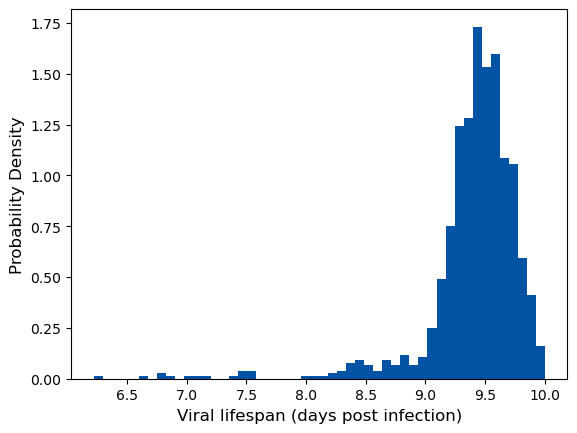

In [6]:
#Set up plot
fig, ax = plt.subplots()

#Plot a histogram of lifespans
ax.hist(Lifespans,bins=50,density=True,color="#0353A4")
ax.set_ylabel("Probability Density",fontsize=12)
ax.set_xlabel("Viral lifespan (days post infection)",fontsize=12)
plt.savefig('Plots/Lifespans_adaptive.pdf', dpi=2400,bbox_inches='tight')
plt.show()

In [20]:
#Plot the median of r over time, with a 95% confidence interval
x = np.linspace(0, 10, 41)
y = np.zeros(41)
ci_u = np.zeros(41)
ci_l = np.zeros(41)
for i in range(0, 41):
    r_i = []
    for j in range(1000):
        r_i.append(r_vals[j][i])
    #calculate median and confidence interval at this time point
    y[i] = np.median(np.array(r_i))
    ci_u[i] = np.percentile(np.array(r_i), 97.5)
    ci_l[i] = np.percentile(np.array(r_i), 2.5)

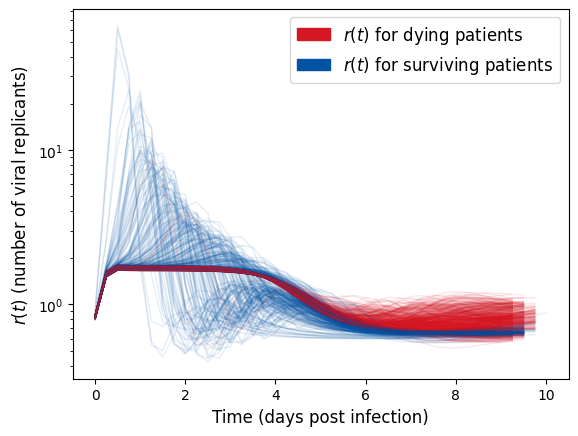

In [21]:
import matplotlib.patches as mpatches

for j in range(1000):
    L = Lifespans[j]
    gens = int(L / g) + 1
    r_curve = r_vals[j]
    if Deaths[j]:
        plt.semilogy(x[0:gens], r_curve[0:gens], '#D51623', linewidth=1, alpha = 0.1)
    else:
        plt.semilogy(x[0:gens], r_curve[0:gens], '#0353A4', linewidth=1, alpha = 0.1)


red_patch = mpatches.Patch(color='#D51623', label=r'$r(t)$ for dying patients')
blue_patch = mpatches.Patch(color='#0353A4', label=r'$r(t)$ for surviving patients')

plt.legend(handles=[red_patch, blue_patch],fontsize=12)
plt.ylabel(r'$r(t)$ (number of viral replicants)',fontsize=12)
plt.xlabel('Time (days post infection)',fontsize=12)
plt.savefig('Plots/r_surv_death_adaptive.pdf', dpi=2400,bbox_inches='tight')

plt.show()

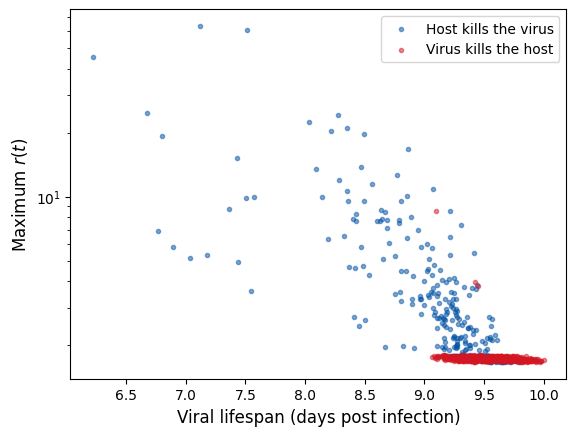

In [22]:
#Plot max r value vs lifespan
ma = []
for i in range(0,len(Lifespans)):
    ma.append(max(r_vals[i]))


dead_lifespans = []
ma_dead = []

end_of_infection = []
ma_end = []

for i in range(0,len(Lifespans)):
    if Deaths[i]:
        dead_lifespans.append(Lifespans[i])
        ma_dead.append(ma[i])
        #ma_dead.append(np.log(np.log(ma[i])))

    else:
        end_of_infection.append(Lifespans[i])
        ma_end.append(ma[i])
        #ma_end.append(np.log(np.log(ma[i])))



fig, ax = plt.subplots()
ax.scatter(end_of_infection, ma_end, c='#0353A4', label='Host kills the virus', marker=".", alpha = 0.5)
ax.scatter(dead_lifespans, ma_dead, c='#D51623', label='Virus kills the host', marker=".", alpha = 0.5)


#ax.set_yscale('linear')
ax.set_yscale('log')

plt.legend()
#plt.ylabel('Maximum loglog(r) value')
plt.ylabel(r'Maximum $r(t)$',fontsize=12)
plt.xlabel('Viral lifespan (days post infection)',fontsize=12)
plt.savefig('Plots/max_r_adaptive.pdf', dpi=2400,bbox_inches='tight')
plt.show()

In [17]:
#plot median virion count over time, with 95% confidence interval
#initialise arrays
x = np.linspace(0, 10, 41)
y = np.zeros(41)
meanV = np.zeros(41)
ci_u = np.zeros(41)
ci_l = np.zeros(41)
for i in range(0, 41):
    v_i = []
    for j in range(1000):
        for k in range(0,numberpeople1000s):
            L = Lifespans[j]
            gens = int(L / g)
            if i <= gens:
                v_i.append(n_i_lists[k + numberpeople1000s * j][0][i])
    #calculate median, mean and confidence interval
    y[i] = np.median(np.array(v_i))
    ci_u[i] = np.percentile(np.array(v_i), 97.5)
    ci_l[i] = np.percentile(np.array(v_i), 2.5)
    meanV[i] = np.mean(np.array(v_i))

1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
999000
999000
998000
995000
992000
989000
985000
985000
980000
961000
948000
922000
800000
436000
109000
1000


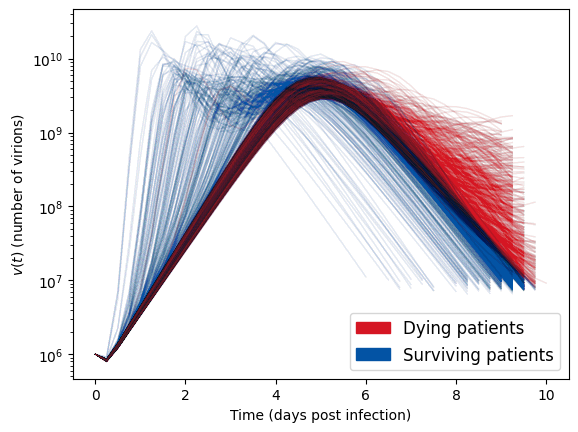

In [18]:
import matplotlib.patches as mpatches

for j in range(1000):
    for k in range(0,10):
        Vcurve = n_i_lists[k + numberpeople1000s * j][0]
        if Deaths[j]:
            plt.semilogy(x[0:len(Vcurve)], Vcurve, '#D51623', linewidth=1, alpha = 0.01)
        else:
            plt.semilogy(x[0:len(Vcurve)], Vcurve, '#0353A4', linewidth=1, alpha = 0.01)


red_patch = mpatches.Patch(color='#D51623', label='Dying patients')
blue_patch = mpatches.Patch(color='#0353A4', label='Surviving patients')

plt.legend(handles=[red_patch, blue_patch],fontsize=12)
plt.ylabel(r'$v(t)$ (number of virions)')
plt.xlabel('Time (days post infection)')
plt.savefig('Plots/v_bpm_surv_dead_adaptive.pdf', dpi=2400,bbox_inches='tight')
plt.show()

0.113


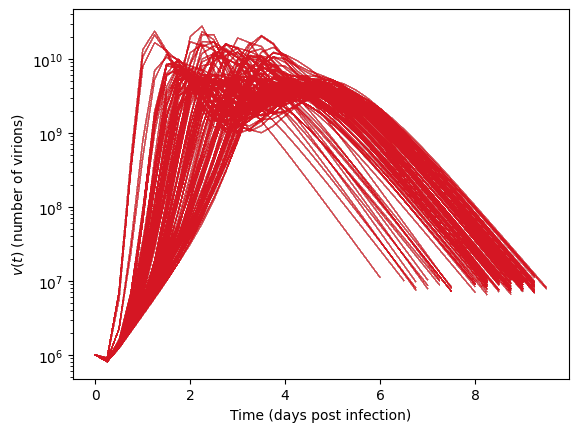

In [23]:
totals = 0
earlys = 0
for j in range(1000):
    for k in range(0,100):
        totals +=1
        Vcurve = n_i_lists[k + numberpeople1000s * j][0]
        peak_time = x[np.argmax(Vcurve)]
        if peak_time < 4:
            plt.semilogy(x[0:len(Vcurve)], Vcurve, '#D51623', linewidth=1, alpha = 0.01)
            earlys += 1

print(earlys / totals)

plt.ylabel(r'$v(t)$ (number of virions)')
plt.xlabel('Time (days post infection)')
plt.show()

In [ ]:
#plot median virion count over time, with 95% confidence interval
#we do this for dead and alive seperately
#initialise arrays
x = np.linspace(0, 10, 41)
y_d = np.zeros(41)
y_a = np.zeros(41)
meanV_d = np.zeros(41)
meanV_a = np.zeros(41)
ci_u_d= np.zeros(41)
ci_l_d = np.zeros(41)
ci_u_a= np.zeros(41)
ci_l_a = np.zeros(41)
for i in range(0, 41):
    v_i_d = []
    v_i_a = []
    for j in range(1000):
        for k in range(0,int(numberpeople1000s)):
            L = Lifespans[j]
            gens = int(L / g)
            if i <= gens:
                if Deaths[j]:
                    v_i_d.append(n_i_lists[k + int(numberpeople1000s) * j][0][i])
                else:
                    v_i_a.append(n_i_lists[k + int(numberpeople1000s) * j][0][i])

    print(i)
    print(len(v_i_a))

    #calculate median, mean and confidence interval
    y_d[i] = np.median(np.array(v_i_d))
    ci_u_d[i] = np.percentile(np.array(v_i_d), 97.5)
    ci_l_d[i] = np.percentile(np.array(v_i_d), 2.5)
    meanV_d[i] = np.mean(np.array(v_i_d))

    y_a[i] = np.median(np.array(v_i_a))
    ci_u_a[i] = np.percentile(np.array(v_i_a), 97.5)
    ci_l_a[i] = np.percentile(np.array(v_i_a), 2.5)
    meanV_a[i] = np.mean(np.array(v_i_a))

#plot
fig, ax = plt.subplots()
ax.semilogy(x,y_d, label = 'median value (deaths)', color='r')
ax.fill_between(x, (ci_l_d), (ci_u_d), color='r', alpha=.1, label="95% confidence interval (deaths)")
ax.semilogy(x,y_a, label = 'median value (alive)', color='b')
ax.fill_between(x, (ci_l_a), (ci_u_a), color='b', alpha=.1, label="95% confidence interval (alive)")
ax.legend()
plt.ylabel('v - number of virions')
plt.xlabel('time (days)')
plt.savefig('Plots/v_bpm_surv_dead_CI.pdf', dpi=1200,bbox_inches='tight')
plt.show()


In [26]:
#We calculate the totals of each type of virion
n_totals = np.zeros((6,41))
for i in range(0,1000 * numberpeople1000s):
    for j in range(0,6):
        n_totals[j,0:len(n_i_lists[i][j])] += n_i_lists[i][j]
N_TOTAL = np.sum(n_totals, axis = 0)

#set up time values
timevals = np.linspace(0,10,41)

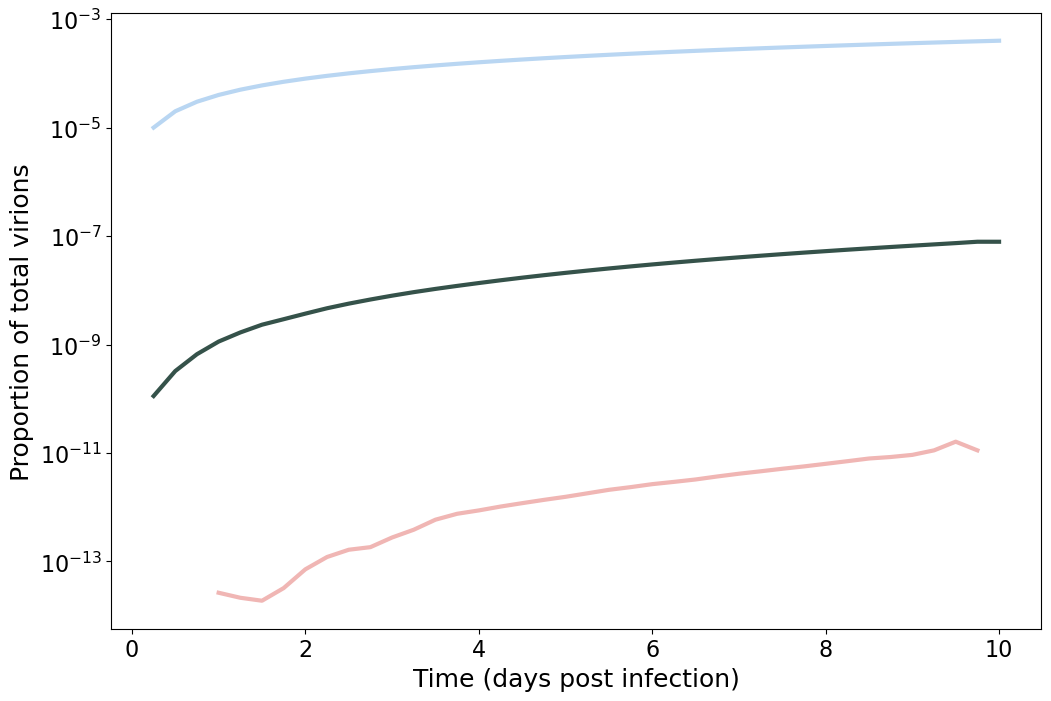

In [33]:
#set up colors for the plot
plotcolors = ['#B9D6F2', '#35524A', '#F0B6B4', '#2A1E5C','#D62828']
linestyles = ['solid',(0,(5,10)),(0,(3,10,1,10)),(0,(5,1)),(0, (3, 1, 1, 1, 1, 1))]
#Set up plot
fig, ax1 = plt.subplots(figsize=(12,8))

#We plot the proportions of each virion type over time
for i in range(1,6):
    prop = n_totals[i,:] / N_TOTAL
    myrange = np.where(prop>0)
    #create a label
    if i >= 2:
        mylabel = str(i) + " mutations"
    else:
        mylabel = "1 mutation"
    if len(myrange[0]) > 0:
        ax1.semilogy(timevals[myrange], prop[myrange], label = mylabel,color=plotcolors[i-1],linewidth=3)
# ax1.legend(loc='lower right',fontsize=12,handlelength=6)
plt.ylabel('Proportion of total virions',fontsize=18)
plt.xlabel('Time (days post infection)',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Plots/prop_standard_adaptive.pdf', dpi=2400,bbox_inches='tight')
plt.show()

In [28]:
# We calculate the proportion / probability of an individual having at least one of a virion type
n_totals_prob = np.zeros((5,41))
for i in range(0,1000 * numberpeople1000s):
    for j in range(1,6):
        myN = n_i_lists[i][j]
        if np.max(myN) > 0.5:
            myrange = np.where(myN>0)
            n_totals_prob[j-1,myrange] += 1
n_totals_prob = n_totals_prob / (1000 * numberpeople1000s)



meanV = np.zeros(41)
for i in range(0, 41):
    v_i = []
    for j in range(1000):
        for k in range(0,numberpeople1000s):
            L = Lifespans[j]
            gens = int(L / g)
            if i <= gens:
                v_i.append(n_i_lists[k + numberpeople1000s * j][0][i])
    #calculate mean
    meanV[i] = np.nanmean(np.array(v_i))

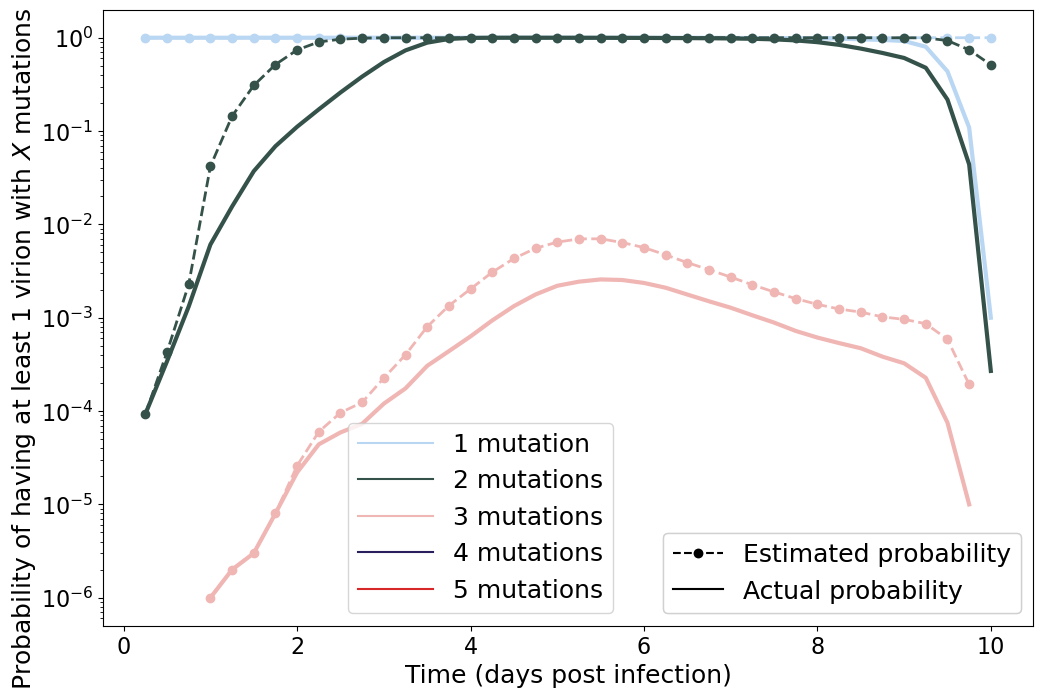

In [65]:
from matplotlib.lines import Line2D
#set up colors for the plot
plotcolors = ['#B9D6F2', '#35524A', '#F0B6B4', '#2A1E5C','#D62828']
linestyles = ['solid',(0,(5,10)),(0,(3,10,1,10)),(0,(5,1)),(0, (3, 1, 1, 1, 1, 1))]

#Set up plot
fig, ax2 = plt.subplots(figsize=(12,8))
# fig.set_figwidth(12)
# fig.set_figheight(8)

for i in range(1,6):
    probs = n_totals_prob[i-1,:]
    myrange = np.where(probs>0)


    #make an estimate for the probability
    prop = n_totals[i,:] / N_TOTAL
    myrange = np.where(prop>0)
    probest = 1 - np.power((1 - prop[myrange]),meanV[myrange])

    #create our label
    if i >= 2:
        mylabel = str(i) + " mutations"
    else:
        mylabel = "1 mutation"
    if len(myrange[0]) > 0:
        ax2.semilogy(timevals[myrange], probs[myrange], color = plotcolors[i-1],linewidth = 3, label = mylabel)
        ax2.semilogy(timevals[myrange], probest,linestyle='--',marker='o',color = plotcolors[i-1],linewidth=2)

leg = [Line2D([0],[0],label='1 mutation',color=plotcolors[0]),Line2D([0],[0],label='2 mutations',color=plotcolors[1]),
       Line2D([0],[0],label='3 mutations',color=plotcolors[2]),Line2D([0],[0],label='4 mutations',color=plotcolors[3]),
       Line2D([0],[0],label='5 mutations',color=plotcolors[4])]

leg2 = [Line2D([0],[0],marker='o',linestyle='--',label='Estimated probability',color='k'),Line2D([0],[0],color='k',label='Actual probability')]

ax2.add_artist(plt.legend(handles=leg,fontsize=18,handlelength=3,loc='best', bbox_to_anchor=(0.25,0.35)))
ax2.add_artist(plt.legend(handles=leg2,loc='lower right',fontsize=18))
ax2.set_ylabel(r'Probability of having at least 1 virion with $X$ mutations',fontsize=18)
ax2.yaxis.set_label_coords(-0.07,0.45)
ax2.set_xlabel('Time (days post infection)',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Plots/prob_standard_1_adaptive.pdf', dpi=2400,bbox_inches='tight')
plt.show()

In [55]:
#Set parameters
p = 10**-5
mu = [1, p, p**2, p**3, p**4, p**5]
mu[0] -= np.sum(mu[1:])
initial_viral_load = 1e6

#Number of people (in 1000s)
numberpeople1000s_quick = 1e7

#Initialise lists
n_i_lists_quick = []

#Loop through and do a BPM for each person
for i in range(0,len(Lifespans)):
    print(str((i + 1) / len(Lifespans) * 100 ) + "%")
    t = Lifespans[i]
    #t = 7
    r = r_vals[i]
    #r = np.ones(120) * 2

    out = np.array(BPM_st_vectorised(t,g,r,mu,initial_viral_load * numberpeople1000s_quick))
    ni_list = []
    for k in range(0, 6):
        ni_list.append(out[:,k])
    n_i_lists_quick.append(ni_list)



0.1%
0.2%
0.3%
0.4%
0.5%
0.6%
0.7000000000000001%
0.8%
0.8999999999999999%
1.0%
1.0999999999999999%
1.2%
1.3%
1.4000000000000001%
1.5%
1.6%
1.7000000000000002%
1.7999999999999998%
1.9%
2.0%
2.1%
2.1999999999999997%
2.3%
2.4%
2.5%
2.6%
2.7%
2.8000000000000003%
2.9000000000000004%
3.0%
3.1%
3.2%
3.3000000000000003%
3.4000000000000004%
3.5000000000000004%
3.5999999999999996%
3.6999999999999997%
3.8%
3.9%
4.0%
4.1000000000000005%
4.2%
4.3%
4.3999999999999995%
4.5%
4.6%
4.7%
4.8%
4.9%
5.0%
5.1%
5.2%
5.3%
5.4%
5.5%
5.6000000000000005%
5.7%
5.800000000000001%
5.8999999999999995%
6.0%
6.1%
6.2%
6.3%
6.4%
6.5%
6.6000000000000005%
6.7%
6.800000000000001%
6.9%
7.000000000000001%
7.1%
7.199999999999999%
7.3%
7.3999999999999995%
7.5%
7.6%
7.7%
7.8%
7.9%
8.0%
8.1%
8.200000000000001%
8.3%
8.4%
8.5%
8.6%
8.7%
8.799999999999999%
8.9%
9.0%
9.1%
9.2%
9.3%
9.4%
9.5%
9.6%
9.700000000000001%
9.8%
9.9%
10.0%
10.100000000000001%
10.2%
10.299999999999999%
10.4%
10.5%
10.6%
10.7%
10.8%
10.9%
11.0%
11.1%
11.2000

In [57]:
#READS VALUES TO PICKLE FILE
#BE AWARE THAT THIS FILE WILL BE VERY LARGE (2.5 GB)

with open('n_list_adaptive_quick.pkl', 'wb') as f:  # open a text file
    pickle.dump(n_i_lists_quick, f) # serialize the list   
f.close()

In [17]:
#DO NOT RUN THIS BLOCK IF YOU DO NOT HAVE THE PICKLE FILE
#IMPORTS PICKLE FILE INSTEAD OF ABOVE CALCULATION

with open('n_list_adaptive_quick.pkl', 'rb') as f:

    loaded_n_list = pickle.load(f) # deserialize using load()
f.close()

n_i_lists_quick = loaded_n_list


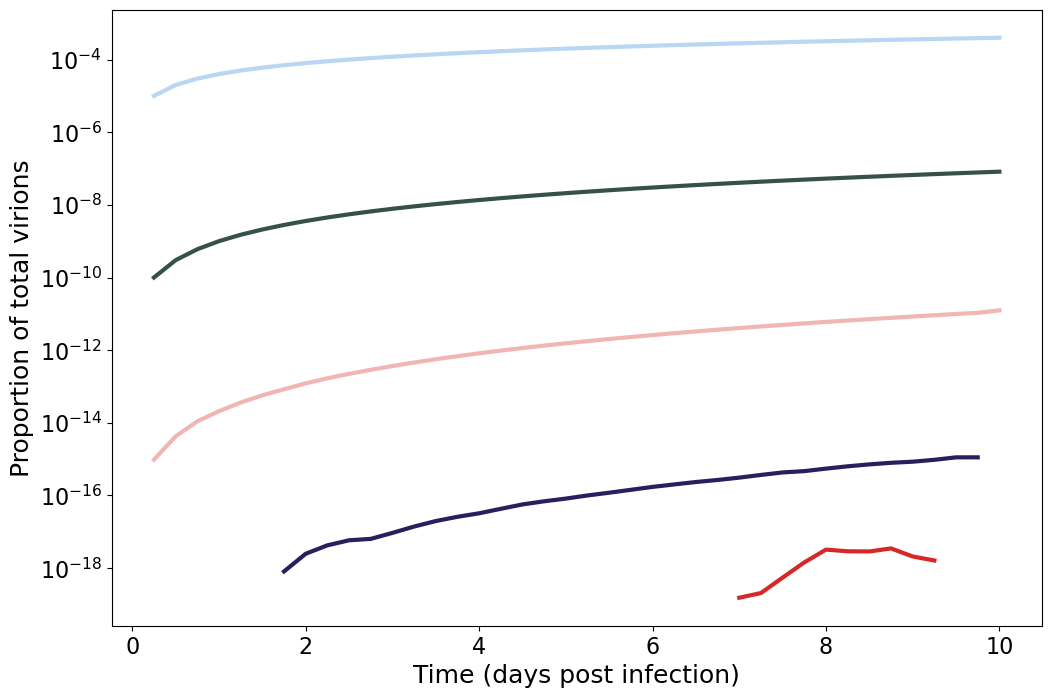

In [66]:
#We calculate the totals of each type of virion
n_totals = np.zeros((6,41))
for i in range(0,1000):
    for j in range(0,6):
        n_totals[j,0:len(n_i_lists_quick[i][j])] += n_i_lists_quick[i][j]
N_TOTAL = np.sum(n_totals, axis = 0)

#set up time values
timevals = np.linspace(0,10,41)

#set up the colors for the plot
plotcolors = ['#B9D6F2', '#35524A', '#F0B6B4', '#2A1E5C','#D62828']
linestyles = ['solid',(0,(5,10)),(0,(3,10,1,10)),(0,(5,1)),(0, (3, 1, 1, 1, 1, 1))]

#Set up plot
fig, ax3 = plt.subplots(figsize=(12,8))

#We plot the proportions of each virion type over time
for i in range(1,6):
    prop = n_totals[i,:] / N_TOTAL
    myrange = np.where(prop>0)
    #create a label
    if i > 2:
        mylabel = str(i) + " out of " + str(i) + " mutations"
    else:
        if i > 1:
            mylabel = "2 mutations"
        else:
            mylabel = "1 mutation"
    if len(myrange[0]) > 0:
        ax3.semilogy(timevals[myrange], prop[myrange], label = mylabel, color=plotcolors[i-1],linewidth=3)
ax3.set_ylabel('Proportion of total virions',fontsize=18)
ax3.set_xlabel('Time (days post infection)',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Plots/prop_quick_adaptive.pdf', dpi=2400,bbox_inches='tight')
plt.show()

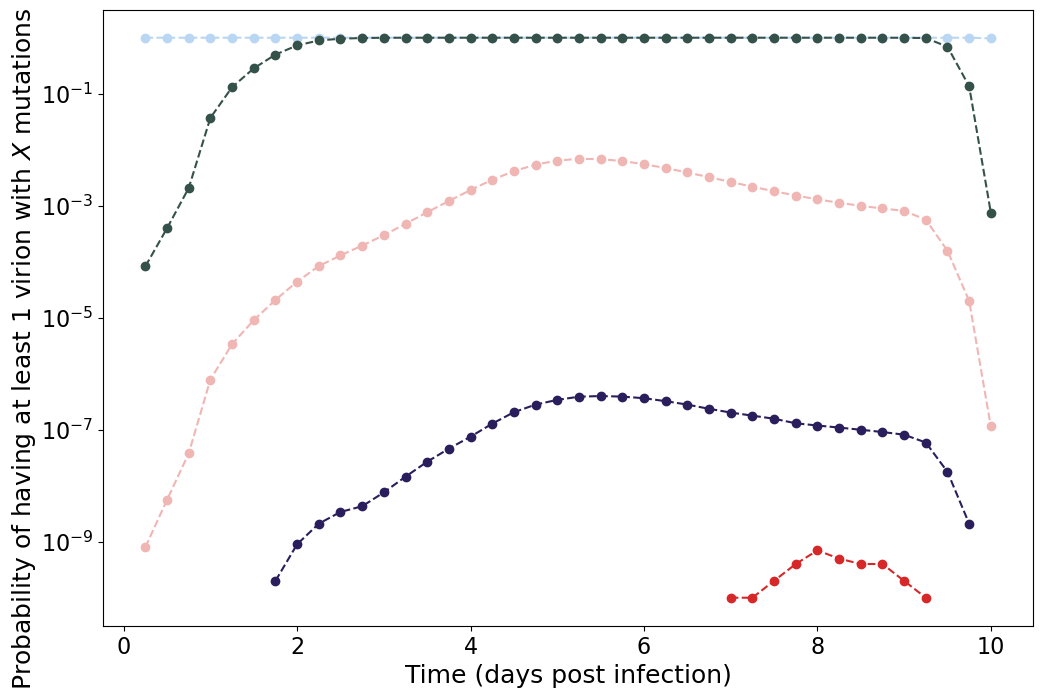

In [82]:
from decimal import *
numberpeople1000s_quick = 1e7
#We calculate the totals of each type of virion
n_totals = np.zeros((6,41))
for i in range(0,1000):
    for j in range(0,6):
        n_totals[j,0:len(n_i_lists_quick[i][j])] += n_i_lists_quick[i][j]
N_TOTAL = np.sum(n_totals, axis = 0)

#set up time values
timevals = np.linspace(0,10,41)

#set up the colors for the plot
plotcolors = ['#B9D6F2', '#35524A', '#F0B6B4', '#2A1E5C','#D62828']
linestyles = ['solid',(0,(5,10)),(0,(3,10,1,10)),(0,(5,1)),(0, (3, 1, 1, 1, 1, 1))]

fig, ax4 = plt.subplots(figsize=(12,8))
# fig.set_figwidth(12)
# fig.set_figheight(8)

for i in range(1,6):
    #make an estimate for the probability
    
    prop = (n_totals[i,:] / N_TOTAL)
    myrange = np.where((prop)>0)

    mynewprop = []
    mynewNTOTAL = []
    result = []


    for k in range(len(myrange[0])):
        mynewprop.append(1 - Decimal(float(prop[myrange[0][k]])))
        mynewNTOTAL.append(Decimal(N_TOTAL[myrange[0][k]] / (1000 * numberpeople1000s_quick)))
        result.append(1 - mynewprop[-1] ** mynewNTOTAL[-1])


    #create our label
    if i > 2:
        mylabel = str(i) + " out of " + str(i) + " mutations"
    else:
        if i > 1:
            mylabel = "2 mutations"
        else:
            mylabel = "1 mutation"

    if len(myrange[0]) > 0:
        ax4.semilogy(timevals[myrange], result, linestyle='--',color=plotcolors[i-1],marker='o', label = mylabel)


# ax4.legend(fontsize=12,loc='lower center',handlelength=3)
ax4.set_ylabel(r'Probability of having at least 1 virion with $X$ mutations',fontsize=18)
ax4.yaxis.set_label_coords(-0.07,0.45)
ax4.set_xlabel('Time (days post infection)',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Plots/prob_quick_1_adaptive.pdf', dpi=2400,bbox_inches='tight')
plt.show()

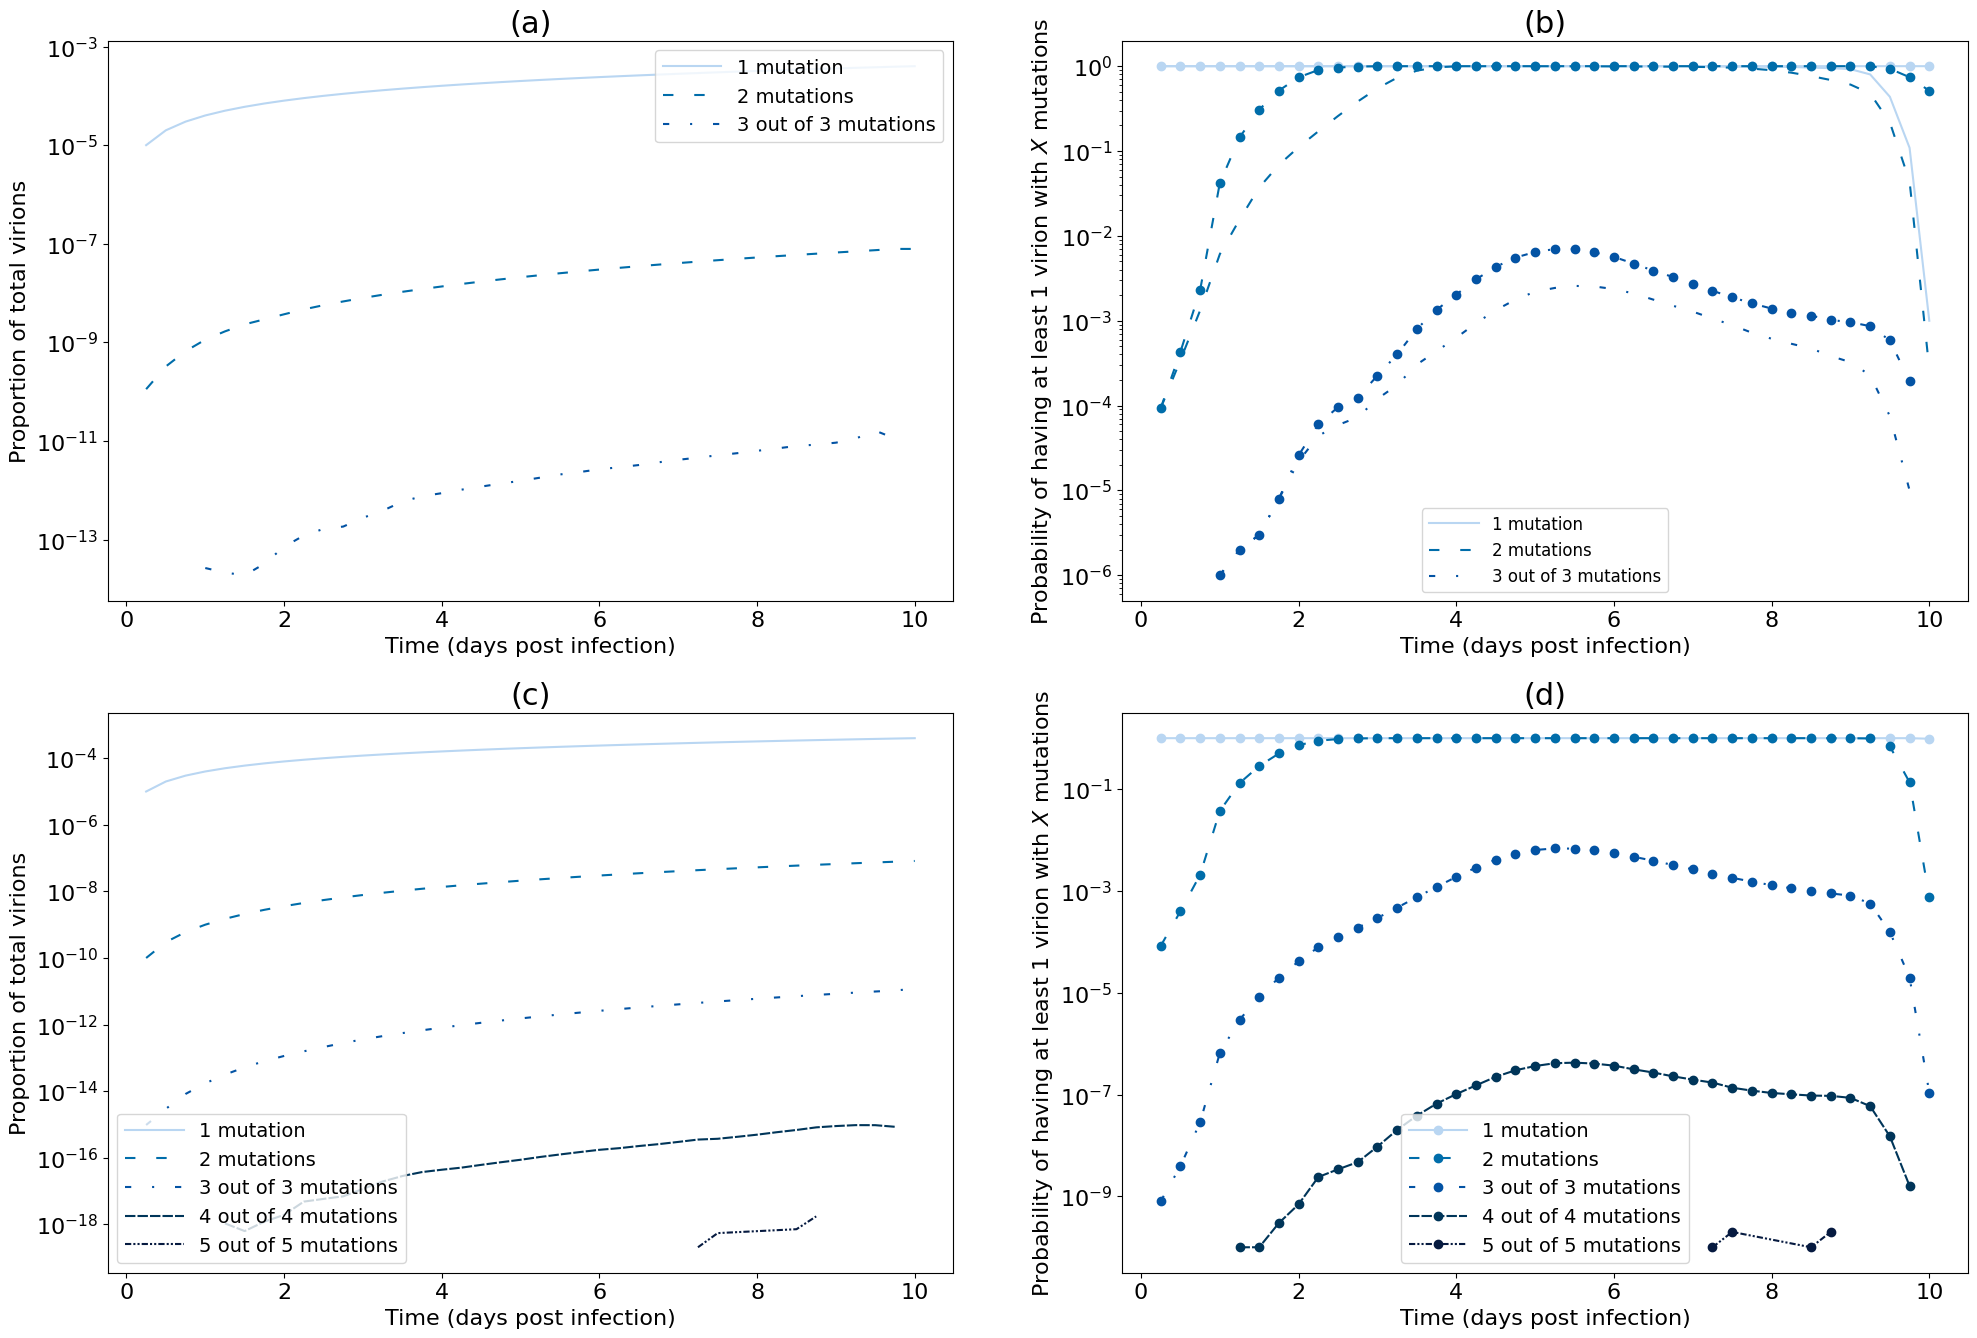

In [52]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(2, 2)
#########################################################

#We calculate the totals of each type of virion
n_totals = np.zeros((6,41))
for i in range(0,1000 * numberpeople1000s):
    for j in range(0,6):
        n_totals[j,0:len(n_i_lists[i][j])] += n_i_lists[i][j]
N_TOTAL = np.sum(n_totals, axis = 0)

#set up time values
timevals = np.linspace(0,10,41)

#set up colors for the plot
plotcolors = ['#B9D6F2', '#006DAA', '#0353A4', '#003559','#061A40']
linestyles = ['solid',(0,(5,10)),(0,(3,10,1,10)),(0,(5,1)),(0, (3, 1, 1, 1, 1, 1))]

#We plot the proportions of each virion type over time
for i in range(1,6):
    prop = n_totals[i,:] / N_TOTAL
    myrange = np.where(prop>0)
    #create a label
    if i > 2:
        mylabel = str(i) + " out of " + str(i) + " mutations"
    else:
        if i > 1:
            mylabel = "2 mutations"
        else:
            mylabel = "1 mutation"
    if len(myrange[0]) > 0:
        axs[0, 0].semilogy(timevals[myrange], prop[myrange], label = mylabel,color=plotcolors[i-1],linestyle=linestyles[i-1])
axs[0,0].set_title('(a)', fontsize=22)
axs[0, 0].legend(loc=1,fontsize=14,handlelength=3)
axs[0, 0].set_ylabel('Proportion of total virions',fontsize=16)
axs[0, 0].set_xlabel('Time (days post infection)',fontsize=16)





###############################################################################

# We calculate the proportion / probability of an individual having at least one of a virion type
n_totals_prob = np.zeros((5,41))
for i in range(0,1000 * numberpeople1000s):
    for j in range(1,6):
        myN = n_i_lists[i][j]
        if np.max(myN) > 0.5:
            myrange = np.where(myN>0)
            n_totals_prob[j-1,myrange] += 1
n_totals_prob = n_totals_prob / (1000 * numberpeople1000s)



meanV = np.zeros(41)
for i in range(0, 41):
    v_i = []
    for j in range(1000):
        for k in range(0,numberpeople1000s):
            L = Lifespans[j]
            gens = int(L / g)
            if i <= gens:
                v_i.append(n_i_lists[k + numberpeople1000s * j][0][i])
    #calculate mean
    meanV[i] = np.nanmean(np.array(v_i))

#set up colors for the plot
plotcolors = ['#B9D6F2', '#006DAA', '#0353A4', '#003559','#061A40']
linestyles = ['solid',(0,(5,10)),(0,(3,10,1,10)),(0,(5,1)),(0, (3, 1, 1, 1, 1, 1))]


for i in range(1,6):
    probs = n_totals_prob[i-1,:]
    myrange = np.where(probs>0)


    #make an estimate for the probability
    prop = n_totals[i,:] / N_TOTAL
    myrange = np.where(prop>0)
    probest = 1 - np.power((1 - prop[myrange]),meanV[myrange])

    #create our label
    if i > 2:
        mylabel = str(i) + " out of " + str(i) + " mutations"
    else:
        if i > 1:
            mylabel = "2 mutations"
        else:
            mylabel = "1 mutation"
    if len(myrange[0]) > 0:
        axs[0, 1].semilogy(timevals[myrange], probs[myrange], color = plotcolors[i-1],linestyle=linestyles[i-1],label = mylabel)
        axs[0, 1].semilogy(timevals[myrange], probest, linestyle=linestyles[i-1],marker='o',color = plotcolors[i-1])

axs[0,1].set_title('(b)', fontsize=22)
axs[0, 1].legend(loc='lower center',fontsize=12,handlelength=3)
axs[0, 1].set_ylabel(r'Probability of having at least 1 virion with $X$ mutations',fontsize=16)
axs[0, 1].set_xlabel('Time (days post infection)',fontsize=16)




###############################################


#We calculate the totals of each type of virion
n_totals = np.zeros((6,41))
for i in range(0,1000):
    for j in range(0,6):
        n_totals[j,0:len(n_i_lists_quick[i][j])] += n_i_lists_quick[i][j]
N_TOTAL = np.sum(n_totals, axis = 0)

#set up time values
timevals = np.linspace(0,10,41)

#set up the colors for the plot
plotcolors = ['#B9D6F2', '#006DAA', '#0353A4', '#003559','#061A40']
linestyles = ['solid',(0,(5,10)),(0,(3,10,1,10)),(0,(5,1)),(0, (3, 1, 1, 1, 1, 1))]


#We plot the proportions of each virion type over time
for i in range(1,6):
    prop = n_totals[i,:] / N_TOTAL
    myrange = np.where(prop>0)
    #create a label
    if i > 2:
        mylabel = str(i) + " out of " + str(i) + " mutations"
    else:
        if i > 1:
            mylabel = "2 mutations"
        else:
            mylabel = "1 mutation"
    if len(myrange[0]) > 0:
        axs[1,0].semilogy(timevals[myrange], prop[myrange], label = mylabel, color=plotcolors[i-1], linestyle=linestyles[i-1])
axs[1,0].set_title('(c)', fontsize=22)
axs[1,0].legend(fontsize=14,handlelength=3)
axs[1,0].set_ylabel('Proportion of total virions',fontsize =16)
axs[1,0].set_xlabel('Time (days post infection)',fontsize = 16)







#######################################################################



from decimal import *

#We calculate the totals of each type of virion
n_totals = np.zeros((6,41))
for i in range(0,1000):
    for j in range(0,6):
        n_totals[j,0:len(n_i_lists_quick[i][j])] += n_i_lists_quick[i][j]
N_TOTAL = np.sum(n_totals, axis = 0)

#set up time values
timevals = np.linspace(0,10,41)

#set up the colors for the plot
plotcolors = ['#B9D6F2', '#006DAA', '#0353A4', '#003559','#061A40']
linestyles = ['solid',(0,(5,10)),(0,(3,10,1,10)),(0,(5,1)),(0, (3, 1, 1, 1, 1, 1))]


for i in range(1,6):
    #make an estimate for the probability
    
    prop = (n_totals[i,:] / N_TOTAL)
    myrange = np.where((prop)>0)

    mynewprop = []
    mynewNTOTAL = []
    result = []


    for k in range(len(myrange[0])):
        mynewprop.append(1 - Decimal(float(prop[myrange[0][k]])))
        mynewNTOTAL.append(Decimal(N_TOTAL[myrange[0][k]] / (1000 * numberpeople1000s_quick)))
        result.append(1 - mynewprop[-1] ** mynewNTOTAL[-1])


    #create our label
    if i > 2:
        mylabel = str(i) + " out of " + str(i) + " mutations"
    else:
        if i > 1:
            mylabel = "2 mutations"
        else:
            mylabel = "1 mutation"

    if len(myrange[0]) > 0:
        axs[1,1].semilogy(timevals[myrange], result, linestyle=linestyles[i-1],color=plotcolors[i-1],marker='o', label = mylabel)

axs[1,1].set_title('(d)', fontsize=22)
axs[1,1].legend(fontsize=14,loc='lower center',handlelength=3)
axs[1,1].set_ylabel(r'Probability of having at least 1 virion with $X$ mutations',fontsize=16)
axs[1,1].set_xlabel('Time (days post infection)',fontsize=16)

fig.set_figwidth(24)
fig.set_figheight(16)

plt.savefig('Plots/prob_plots_grid_adaptive.pdf', dpi=2400,bbox_inches='tight')
plt.show()


In [ ]:
# We calculate the proportion / probability of an individual having at least one of a virion type
n_totals_prob = np.zeros((5,41))
for i in range(0,1000 * numberpeople1000s):
    for j in range(1,6):
        myN = n_i_lists[i][j]
        if np.max(myN) > 0.5:
            myrange = np.where(myN>0)
            n_totals_prob[j-1,myrange] += 1
n_totals_prob = n_totals_prob / (1000 * numberpeople1000s)



meanV = np.zeros(41)
for i in range(0, 41):
    v_i = []
    for j in range(1000):
        for k in range(0,numberpeople1000s):
            L = Lifespans[j]
            gens = int(L / g)
            if i <= gens:
                v_i.append(n_i_lists[k + numberpeople1000s * j][0][i])
    #calculate mean
    meanV[i] = np.nanmean(np.array(v_i))

#set up colors for the plot
plotcolors = ['#B9D6F2', '#006DAA', '#0353A4', '#003559','#061A40']
linestyles = ['solid',(0,(5,10)),(0,(3,10,1,10)),(0,(5,1)),(0, (3, 1, 1, 1, 1, 1))]

#Set up plot
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)

for i in range(1,6):
    probs = n_totals_prob[i-1,:]
    myrange = np.where(probs>0)


    #make an estimate for the probability
    prop = n_totals[i,:] / N_TOTAL
    myrange = np.where(prop>0)
    probest = 1 - np.power((1 - prop[myrange]),meanV[myrange])

    #create our label
    if i > 2:
        mylabel = str(i) + " out of " + str(i) + " mutations"
    else:
        if i > 1:
            mylabel = "2 mutations"
        else:
            mylabel = "1 mutation"
    if len(myrange[0]) > 0:
        ax.semilogy(timevals[myrange], probs[myrange], color = plotcolors[i-1],linestyle=linestyles[i-1],label = mylabel)
        ax.semilogy(timevals[myrange], probest, linestyle=linestyles[i-1],marker='o',color = plotcolors[i-1])


ax.legend(loc='lower center',fontsize=12,handlelength=3)
ax.set_ylabel(r'Probability of having at least 1 virion with $X$ mutations',fontsize=12)
ax.set_xlabel('Time (days post infection)',fontsize=12)
plt.savefig('Plots/prob_standard_1_adaptive.pdf', dpi=2400,bbox_inches='tight')
plt.show()

from decimal import *
#We calculate the totals of each type of virion
n_totals = np.zeros((6,41))
for i in range(0,1000):
    for j in range(0,6):
        n_totals[j,0:len(n_i_lists_quick[i][j])] += n_i_lists_quick[i][j]
N_TOTAL = np.sum(n_totals, axis = 0)

#set up time values
timevals = np.linspace(0,10,41)

#set up the colors for the plot
plotcolors = ['#B9D6F2', '#006DAA', '#0353A4', '#003559','#061A40']
linestyles = ['solid',(0,(5,10)),(0,(3,10,1,10)),(0,(5,1)),(0, (3, 1, 1, 1, 1, 1))]

#Set up plot
fig, ax = plt.subplots()

#We plot the proportions of each virion type over time
for i in range(1,6):
    prop = n_totals[i,:] / N_TOTAL
    myrange = np.where(prop>0)
    #create a label
    if i > 2:
        mylabel = str(i) + " out of " + str(i) + " mutations"
    else:
        if i > 1:
            mylabel = "2 mutations"
        else:
            mylabel = "1 mutation"
    if len(myrange[0]) > 0:
        ax.semilogy(timevals[myrange], prop[myrange], label = mylabel, color=plotcolors[i-1], linestyle=linestyles[i-1])
ax.legend(fontsize=12,handlelength=3)
ax.set_ylabel('Proportion of total virions',fontsize =12)
ax.set_xlabel('Time (days post infection)',fontsize = 12)
plt.savefig('Plots/prop_quick_adaptive.pdf', dpi=2400,bbox_inches='tight')
plt.show()


#We calculate the totals of each type of virion
n_totals = np.zeros((6,41))
for i in range(0,1000):
    for j in range(0,6):
        n_totals[j,0:len(n_i_lists_quick[i][j])] += n_i_lists_quick[i][j]
N_TOTAL = np.sum(n_totals, axis = 0)

#set up time values
timevals = np.linspace(0,10,41)

#set up the colors for the plot
plotcolors = ['#B9D6F2', '#006DAA', '#0353A4', '#003559','#061A40']
linestyles = ['solid',(0,(5,10)),(0,(3,10,1,10)),(0,(5,1)),(0, (3, 1, 1, 1, 1, 1))]

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)

for i in range(1,6):
    #make an estimate for the probability
    
    prop = (n_totals[i,:] / N_TOTAL)
    myrange = np.where((prop)>0)

    mynewprop = []
    mynewNTOTAL = []
    result = []


    for k in range(len(myrange[0])):
        mynewprop.append(1 - Decimal(float(prop[myrange[0][k]])))
        mynewNTOTAL.append(Decimal(N_TOTAL[myrange[0][k]] / (1000 * numberpeople1000s_quick)))
        result.append(1 - mynewprop[-1] ** mynewNTOTAL[-1])


    #create our label
    if i > 2:
        mylabel = str(i) + " out of " + str(i) + " mutations"
    else:
        if i > 1:
            mylabel = "2 mutations"
        else:
            mylabel = "1 mutation"

    if len(myrange[0]) > 0:
        ax.semilogy(timevals[myrange], result, linestyle=linestyles[i-1],color=plotcolors[i-1],marker='o', label = mylabel)


ax.legend(fontsize=12,loc='lower center',handlelength=3)
ax.set_ylabel(r'Probability of having at least 1 virion with $X$ mutations',fontsize=12)
ax.set_xlabel('Time (days post infection)',fontsize=12)
plt.savefig('Plots/quad_bpm_plots.pdf', dpi=2400,bbox_inches='tight')
plt.show()